In [18]:
import os, random, math

from tqdm import tqdm
from PIL import Image, ImageEnhance, ImageOps
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

from itertools import combinations
from sklearn.metrics import roc_curve

from DeepPrint.pretrained import DeepPrintNet
from tools.eer import evaluate_eer_on_test
from tools.display import save_concat_aligned_by_class

In [19]:
def rotate_minutiae_map(H, angle_deg, interp=cv2.INTER_LINEAR):
    """
    Rotates a 3D minutiae map spatially and shifts orientation bins with sub-bin interpolation.
    
    Args:
        H: (H, W, C) numpy array, 6-channel orientation map.
        angle_deg: rotation angle in degrees (positive = counterclockwise)
        interp: interpolation flag for spatial rotation
    Returns:
        H_rot: rotated and channel-interpolated label map
    """
    h, w, n_ori = H.shape
    angle_rad = np.deg2rad(angle_deg)
    # === 1. Spatial rotation ===
    # Center for rotation
    center = (w/2, h/2)
    M = cv2.getRotationMatrix2D(center, angle_deg, 1.0)
    H_rot = np.zeros_like(H)
    for k in range(n_ori):
        H_rot[..., k] = cv2.warpAffine(H[..., k], M, (w, h), flags=interp, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

    # === 2. Orientation channel interpolation ===
    # How many bins to shift (can be fractional)
    bin_width = 2 * np.pi / n_ori
    shift = angle_rad / bin_width   # e.g., 1.5 bins = roll 1 bin, 50% blend with next
    int_shift = int(np.floor(shift)) % n_ori
    frac_shift = shift - np.floor(shift)
    
    # Roll channels and linearly interpolate between bins
    H_shifted = np.zeros_like(H_rot)
    for k in range(n_ori):
        k0 = (k - int_shift) % n_ori
        k1 = (k0 - 1) % n_ori  # for interpolation, next bin
        H_shifted[..., k] = (1 - frac_shift) * H_rot[..., k0] + frac_shift * H_rot[..., k1]
    return H_shifted

# Scan all samples in both splits:
all_samples = [
    fname[:-4]
    for split in ["training", "validation"]
    for fname in os.listdir(f"../../datasets/fingerprints/{split}/images")
    if fname.endswith('.png')
]
all_ids = sorted({s.split('_')[0] for s in all_samples})

DEBUG = True
if DEBUG:
    # Limit to the first N classes
    N_CLASSES = 100  # or 1, for the most extreme case
    all_ids = all_ids[:N_CLASSES]

global_id2label = {id_str: i for i, id_str in enumerate(all_ids)}

class DeepPrintDataset(Dataset):
    def __init__(self, root, split='train', ids=None, color_jitter=True, affine_aug=True, id2label=None):
        """
        root: path to dataset root (expects images/ and maps/ subdirs)
        split: 'train' or 'val'
        ids: list of (id, sample_idx) tuples to use, or None to scan all
        color_jitter: whether to use brightness/contrast/sharpness augmentation (train only)
        affine_aug: whether to use random affine (rotation/translation) augmentation (train only)
        """
        self.img_dir = os.path.join(root, "images")
        self.map_dir = os.path.join(root, "maps")
        self.split = split
        self.color_jitter = color_jitter if split == 'train' else False
        self.affine_aug = affine_aug if split == 'train' else False

        if ids is None:
            self.samples = sorted([
                fname[:-4] for fname in os.listdir(self.img_dir)
                if fname.endswith('.png') and os.path.isfile(os.path.join(self.map_dir, fname.replace('.png', '.npy')))
            ])
        else:
            self.samples = ids

        if id2label is not None:
            self.id2label = id2label
        else:
            # Fallback to old behavior if no mapping is provided
            self.id2label = {}
            for s in self.samples:
                id_str = s.split('_')[0]
                if id_str not in self.id2label:
                    self.id2label[id_str] = len(self.id2label)
        self.num_classes = len(self.id2label)
        print(f'{len(self.samples)} images for {len(self.id2label)} classes found for {self.split} split')

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        fname = self.samples[idx]
        img_path = os.path.join(self.img_dir, fname + '.png')
        map_path = os.path.join(self.map_dir, fname + '.npy')
        img = Image.open(img_path).convert('L')
        h_img, w_img = img.height, img.width

        H = np.load(map_path)
        H = torch.from_numpy(H.transpose(2,0,1)).float()
        h_map, w_map = H.shape[1], H.shape[2]

        # Optional: augment image color
        if self.color_jitter:
            enhancers = [
                ImageEnhance.Contrast,
                ImageEnhance.Brightness,
                ImageEnhance.Sharpness
            ]
            for enhancer in enhancers:
                factor = random.uniform(0.8, 1.2)
                img = enhancer(img).enhance(factor)

        # Optional: joint affine (rotation, translation) - affects both image and map
        # map has to be interpolated to new values, complicated stuff lol.
        if self.affine_aug:
            angle = random.uniform(-15, 15)
            tx = random.uniform(-0.05, 0.05) * w_img
            ty = random.uniform(-0.05, 0.05) * h_img

            img = TF.affine(img, angle=angle, translate=(tx, ty), scale=1.0, shear=0, fill=255)

            map_np = H.permute(1, 2, 0).numpy()
            rotated_map = rotate_minutiae_map(map_np, angle_deg=-angle)
            if rotated_map.max() > 0:
                rotated_map = rotated_map / rotated_map.max()
            H = torch.from_numpy(rotated_map).permute(2, 0, 1)
            H = TF.affine(H, angle=0, translate=(tx * (w_map / w_img), ty * (h_map / h_img)), scale=1.0, shear=0, fill=0)

        # Version for translation only
        # if self.affine_aug:
        #     angle = 0
        #     tx = random.uniform(-0.05, 0.05) * w_img
        #     ty = random.uniform(-0.05, 0.05) * h_img
        #     img = TF.affine(img, angle=angle, translate=(tx, ty), scale=1.0, shear=0, fill=255)
        #     H = TF.affine(H, angle=angle, translate=(tx * (w_map / w_img), ty * (h_map / h_img)),
        #                   scale=1.0, shear=0, fill=0)

        # Random crop
        crop_size = 448
        map_crop = 192

        # TODO: we may want to accept smaller images later...
        assert h_img >= crop_size and w_img >= crop_size, "Image too small!"
        assert h_map >= map_crop and w_map >= map_crop, "Map too small!" 

        x_img = random.randint(0, w_img - crop_size)
        y_img = random.randint(0, h_img - crop_size)
        x_map = int(x_img * (w_map / w_img))
        y_map = int(y_img * (h_map / h_img))
        img = img.crop((x_img, y_img, x_img + crop_size, y_img + crop_size))
        H = H[:, y_map:y_map+map_crop, x_map:x_map+map_crop]
        # H *= 100.

        # To tensor, normalize to [0,1]
        img = TF.to_tensor(img).float()
        label = self.id2label[fname.split('_')[0]]
        return img, label, H
    
train_all_samples = [
    fname[:-4]
    for fname in os.listdir("../../datasets/fingerprints/training/images")
    if fname.endswith('.png')
]

# Only include samples whose ID is in all_ids (the first N classes)
train_samples = [s for s in train_all_samples if s.split('_')[0] in all_ids]

val_all_samples = [
    fname[:-4]
    for fname in os.listdir("../../datasets/fingerprints/validation/images")
    if fname.endswith('.png')
]

val_samples = [s for s in val_all_samples if s.split('_')[0] in all_ids]

print(len(train_samples), len(val_samples))

500 20


In [20]:
if DEBUG:
    train_set = DeepPrintDataset(root='../../datasets/fingerprints/training', split='train', ids=train_samples, id2label=global_id2label)
    val_set = DeepPrintDataset(root='../../datasets/fingerprints/validation', split='val', ids=val_samples, id2label=global_id2label)
else:
    train_set = DeepPrintDataset(root='../../datasets/fingerprints/training', split='train', id2label=global_id2label)
    val_set = DeepPrintDataset(root='../../datasets/fingerprints/validation', split='val', id2label=global_id2label)

500 images for 100 classes found for train split
20 images for 100 classes found for val split


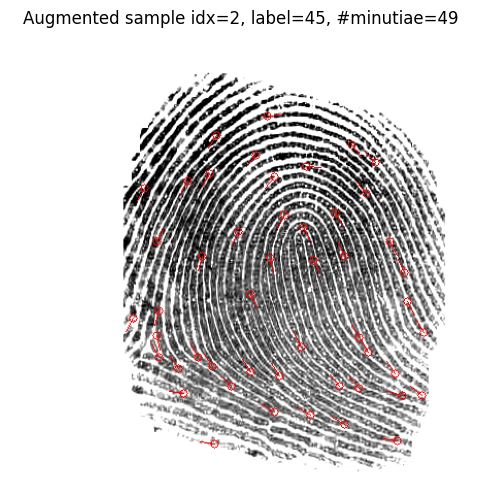

In [21]:
import matplotlib.pyplot as plt
from tools.display import extract_minutiae_from_map, draw_minutiae_on_image
import cv2

idx = 2
img, label, H = train_set.__getitem__(idx)

img_np = (img.squeeze().numpy() * 255).astype(np.uint8)
map_np = H.permute(1, 2, 0).numpy()
h_img, w_img = img_np.shape
h_map, w_map = H.shape[1], H.shape[2]

# Extract minutiae from map
minutiae = extract_minutiae_from_map(map_np, 0.5, 5)

# Draw on image
img_with_minutiae = draw_minutiae_on_image(img_np, minutiae, map_shape=(h_map, w_map), img_shape=(h_img, w_img))

plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(img_with_minutiae, cv2.COLOR_BGR2RGB))
plt.title(f"Augmented sample idx={idx}, label={label}, #minutiae={len(minutiae)}")
plt.axis('off')
plt.show()

In [22]:
# Params for training
num_classes = train_set.num_classes

# Set up GPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print("Using device:", device)
print(f"Found {num_classes} on dataset.")
model = DeepPrintNet(num_classes).to(device)

Using device: cuda
Found 100 on dataset.


In [23]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Apply only to parts that dont have pre-trained weights.
model.minutiae_embed.apply(weights_init)
model.minutiae_map.apply(weights_init)
model.texture_fc.apply(weights_init)
model.classifier1.apply(weights_init)
model.classifier2.apply(weights_init)
model.localization.apply(weights_init)

# # zero localization initial vals
# nn.init.zeros_(model.localization.fc[-1].weight)
# nn.init.zeros_(model.localization.fc[-1].bias)

LocalizationNetwork(
  (down): Upsample(size=(128, 128), mode='bilinear')
  (conv): Sequential(
    (0): Conv2d(1, 24, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=3, bias=True)
  )
)

In [24]:
def balanced_mse_loss(pred, target):
    # foreground: target > 0
    foreground = (target > 0).float()
    background = (target == 0).float()
    # Number of foreground and background pixels
    n_fore = foreground.sum()
    n_back = background.sum()
    # Avoid divide-by-zero
    w_fore = 1.0 / (n_fore + 1e-6)
    w_back = 1.0 / (n_back + 1e-6)
    # Assign weights: usually you want foreground weight to be much higher
    weight = foreground * w_fore + background * w_back
    # Compute weighted loss
    loss = ((pred - target) ** 2) * weight
    # Normalize by total pixels (or sum of weights)
    return loss.sum() / weight.sum()

def balanced_mse_loss_per_sample(pred: torch.Tensor, target: torch.Tensor, eps=1e-6) -> torch.Tensor:
    """
    Balanced MSE loss per sample, with per-image foreground/background weighting.
    Args:
        pred: (B, C, H, W)
        target: (B, C, H, W)
    Returns:
        Scalar loss
    """
    B = pred.size(0)
    losses = []

    for i in range(B):
        p = pred[i]
        t = target[i]

        foreground = (t > 0).float()
        background = (t == 0).float()

        n_fore = foreground.sum()
        n_back = background.sum()

        w_fore = 1.0 / (n_fore + eps)
        w_back = 1.0 / (n_back + eps)

        weight = foreground * w_fore + background * w_back
        loss = ((p - t) ** 2 * weight).sum() / weight.sum()
        losses.append(loss)

    return torch.stack(losses).mean()

class CenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim, device='cpu'):
        super().__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim).to(device))

    def forward(self, features, labels):
        # features: [B, feat_dim], labels: [B]
        batch_size = features.size(0)
        centers_batch = self.centers[labels] # [B, feat_dim]
        loss = ((features - centers_batch) ** 2).sum() / batch_size
        return loss
    
def deepprint_loss(
    output,
    labels,
    minutiae_map_gt,
    center_loss_r1,
    center_loss_r2,
    λ1=1.0,
    λ2=0.00125,
    λ3=0.095,
):
    # L1: Cross-entropy on both branches
    loss_ce1 = F.cross_entropy(output['logits1'], labels)
    loss_ce2 = F.cross_entropy(output['logits2'], labels)
    L1 = loss_ce1 + loss_ce2

    # L2: Center loss on both branches
    L2_1 = center_loss_r1(output['R1'], labels)
    L2_2 = center_loss_r2(output['R2'], labels)
    L2 = L2_1 + L2_2

    # L3: Minutiae map MSE
    # L3 = F.mse_loss(output['minutiae_map'], minutiae_map_gt)
    L3 = balanced_mse_loss_per_sample(output['minutiae_map'], minutiae_map_gt)

    # Weighted sum
    total_loss = λ1 * L1 + λ2 * L2 + λ3 * L3

    return total_loss, {'L1': L1.item(), 'L2': L2.item(), 'L3': L3.item()}

In [25]:
base_lr = 0.0001  # You can tune this as needed

center_loss_r1 = CenterLoss(num_classes, 96, device=device)
center_loss_r2 = CenterLoss(num_classes, 96, device=device)

#
# Insane optimizer magic to apply different LR
# to different parts of the model.
#
optimizer = torch.optim.RMSprop(
    [
        # Main model params (excluding localization, center loss)
        {'params': [p for n, p in model.named_parameters() if not n.startswith('localization.') and 'center_loss' not in n]},
        # Localization network, scaled LR
        {'params': model.localization.parameters(), 'lr': base_lr * 0.035}, # 0.035
        # Center loss params, scaled LR
        {'params': center_loss_r1.parameters(), 'lr': 0.5 * base_lr},
        {'params': center_loss_r2.parameters(), 'lr': 0.5 * base_lr},
    ],
    lr=base_lr,
    weight_decay=0.00004
)

In [26]:
from torch.utils.tensorboard import SummaryWriter
from tools.display import extract_minutiae_from_map, draw_minutiae_on_image
import cv2
import time

writer = SummaryWriter("runs/deepprint_exp1")

0it [00:00, ?it/s]


tensor([0.5236], device='cuda:0', grad_fn=<SelectBackward0>)


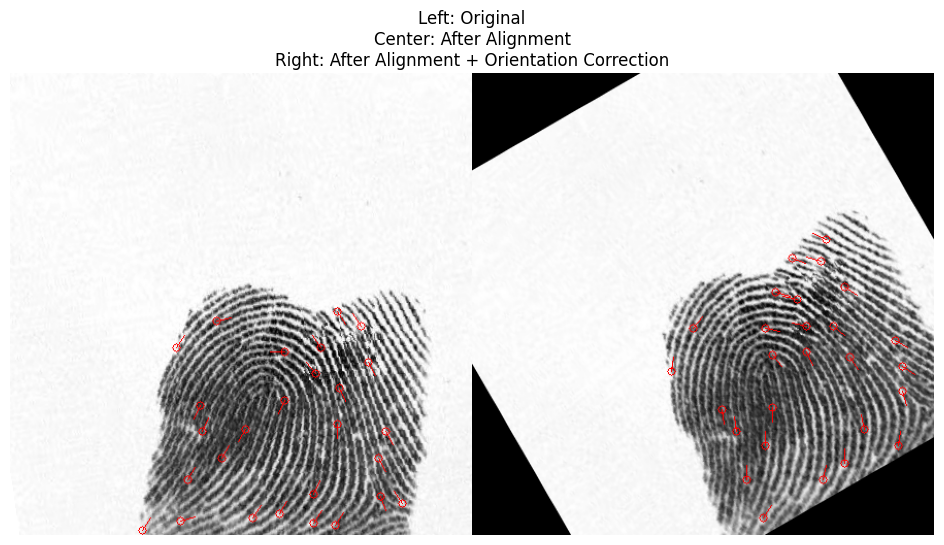

In [ ]:
def shift_minutiae_orientation_bins_torch(H: torch.Tensor, angle_rad: torch.Tensor) -> torch.Tensor:
    """
    Correctly shift orientation bins in a minutiae map by -angle_rad, undoing a rotation.
    Args:
        H: (B, 6, H, W) tensor
        angle_rad: (B,) tensor of *image rotation* (positive = CCW), so we shift *CW* to compensate
    Returns:
        H_shifted: (B, 6, H, W)
    """
    B, C, H_, W_ = H.shape
    bin_width = 2 * np.pi / C
    shift = -angle_rad / bin_width  # Note the negative sign to invert the rotation
    shift_floor = torch.floor(shift)
    int_shift = shift_floor.to(torch.long) % C
    frac_shift = (shift - shift_floor).unsqueeze(1)  # (B, 1)

    # Create base indices
    base_idx = torch.arange(C, device=H.device).float().view(1, -1)  # (1, C)

    # Compute effective indices for each bin
    idx_float = (base_idx - shift.unsqueeze(1)) % C  # (B, C)

    k0 = idx_float.floor().long() % C
    k1 = (k0 - 1) % C
    frac = (idx_float - k0.float()).unsqueeze(2).unsqueeze(3)  # (B, C, 1, 1)

    idx0 = k0.unsqueeze(2).unsqueeze(3).expand(B, C, H_, W_)
    idx1 = k1.unsqueeze(2).unsqueeze(3).expand(B, C, H_, W_)
    batch_idx = torch.arange(B, device=H.device).view(B, 1, 1, 1).expand(B, C, H_, W_)

    gather0 = torch.gather(H, 1, idx0)
    gather1 = torch.gather(H, 1, idx1)

    return (1 - frac) * gather0 + frac * gather1

train_loader = DataLoader(train_set, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)
tqdm_bar = tqdm(enumerate(train_loader))
for batch_idx, (imgs, labels, maps) in tqdm_bar:
    imgs, labels, maps = imgs.to(device), labels.to(device), maps.to(device)
    outputs = model(imgs)
    break

# ---- Get predicted alignment ----
B, C, H, W = maps.shape
tx = outputs['alignment'][:, 0] / W
ty = outputs['alignment'][:, 1] / H
theta = outputs['alignment'][:, 2]
print(theta)

cos_theta = torch.cos(theta)
sin_theta = torch.sin(theta)

affine = torch.zeros((B, 2, 3), device=maps.device, dtype=maps.dtype)
affine[:, 0, 0] = cos_theta
affine[:, 0, 1] = -sin_theta
affine[:, 1, 0] = sin_theta
affine[:, 1, 1] = cos_theta
affine[:, 0, 2] = tx
affine[:, 1, 2] = ty

# ---- Apply alignment to maps ----
grid = F.affine_grid(affine, size=maps.size(), align_corners=False)
aligned_maps = F.grid_sample(maps, grid, mode='bilinear', padding_mode='zeros', align_corners=False)

# Normalize
max_vals = aligned_maps.view(B, -1).amax(dim=1, keepdim=True).clamp(min=1e-5)
aligned_maps = aligned_maps / max_vals.view(B, 1, 1, 1)

# ---- Apply orientation correction ----
final_map = shift_minutiae_orientation_bins_torch(aligned_maps, theta)
if final_map.max() > 0:
    final_map = final_map / final_map.max()

# ---- Get input and aligned images (first sample) ----
original_img = imgs[0].detach().cpu().squeeze().numpy()
aligned_img = outputs['aligned'][0].detach().cpu().squeeze().numpy()

original_img_uint8 = (original_img * 255).astype(np.uint8)
aligned_img_uint8 = (aligned_img * 255).astype(np.uint8)

h_img, w_img = aligned_img_uint8.shape
h_map, w_map = H, W

# ---- Extract minutiae ----
minutiae_original = extract_minutiae_from_map(maps[0].permute(1, 2, 0).detach().cpu().numpy(), 0.5)
# minutiae_aligned = extract_minutiae_from_map(aligned_maps[0].permute(1, 2, 0).detach().cpu().numpy(), 0.5)
minutiae_shifted = extract_minutiae_from_map(final_map[0].permute(1, 2, 0).detach().cpu().numpy(), 0.5)

# ---- Draw overlays ----
img_ori_overlay = draw_minutiae_on_image(original_img_uint8, minutiae_original, map_shape=(h_map, w_map), img_shape=(h_img, w_img))
# img_aligned_overlay = draw_minutiae_on_image(aligned_img_uint8, minutiae_aligned, map_shape=(h_map, w_map), img_shape=(h_img, w_img))
img_shifted_overlay = draw_minutiae_on_image(aligned_img_uint8, minutiae_shifted, map_shape=(h_map, w_map), img_shape=(h_img, w_img))

# ---- Concatenate and show ----
concat = cv2.hconcat([
    cv2.cvtColor(img_ori_overlay, cv2.COLOR_BGR2RGB),
    # cv2.cvtColor(img_aligned_overlay, cv2.COLOR_BGR2RGB),
    cv2.cvtColor(img_shifted_overlay, cv2.COLOR_BGR2RGB)
])

plt.figure(figsize=(12, 6))
plt.imshow(concat)
plt.title("Left: Original\nCenter: After Alignment\nRight: After Alignment + Orientation Correction")
plt.axis('off')
plt.show()


In [11]:
# for name, param in model.localization.named_parameters():
#     print(name, param.grad.norm().item() if param.grad is not None else "No grad")

In [12]:
# --- Setup ---
train_loader = DataLoader(train_set, batch_size=5, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=5, shuffle=False, num_workers=1, pin_memory=True)
center_loss_r1 = center_loss_r1.to(device)
center_loss_r2 = center_loss_r2.to(device)

best_val_loss = float('inf')
out_dir = 'checkpoints'
os.makedirs(out_dir, exist_ok=True)
num_epochs = 20

# --- Gradient Accumulation ---
effective_batch = 30 # 30
real_batch = 5 # 6
accum_steps = effective_batch // real_batch

# --- Tensorboard ---
if DEBUG:
    log_interval = 10
else:
    log_interval = 100

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0.0
    n_train = 0
    optimizer.zero_grad()
    tqdm_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"[Train] Epoch {epoch}/{num_epochs}")
    for batch_idx, (imgs, labels, maps) in tqdm_bar:

        torch.cuda.synchronize()
        time.sleep(0.15)  # sleep for 200ms

        imgs, labels, maps = imgs.to(device), labels.to(device), maps.to(device)
        outputs = model(imgs)

        # # TEMP: Add dummy dependency on align_params
        # dummy_loss = outputs['alignment'].pow(2).sum() * 1e-4
        # total_loss = total_loss + dummy_loss

        # Here we take the aligment output and apply it into the map
        # ==== Align the label (minutiae) maps ====

        B, C, H, W = maps.shape
        tx = outputs['alignment'][:, 0] / W
        ty = outputs['alignment'][:, 1] / H
        theta = outputs['alignment'][:, 2]

        cos_theta = torch.cos(theta)
        sin_theta = torch.sin(theta)

        affine = torch.zeros((B, 2, 3), device=maps.device, dtype=maps.dtype)
        affine[:, 0, 0] = cos_theta
        affine[:, 0, 1] = -sin_theta
        affine[:, 1, 0] = sin_theta
        affine[:, 1, 1] = cos_theta
        affine[:, 0, 2] = tx
        affine[:, 1, 2] = ty

        # ---- Apply alignment to maps ----
        grid = F.affine_grid(affine, size=maps.size(), align_corners=False)
        aligned_maps = F.grid_sample(maps, grid, mode='bilinear', padding_mode='zeros', align_corners=False)

        # Normalize
        max_vals = aligned_maps.view(B, -1).amax(dim=1, keepdim=True).clamp(min=1e-5)
        aligned_maps = aligned_maps / max_vals.view(B, 1, 1, 1)

        # ---- Apply orientation correction ----
        final_maps = shift_minutiae_orientation_bins_torch(aligned_maps, theta)    

        # === LOSS STEP
        total_loss, loss_parts = deepprint_loss(
            outputs, labels, final_maps, center_loss_r1, center_loss_r2
        )
        (total_loss / accum_steps).backward()

        # print("\n--- Gradients in Localization Network ---")
        # for name, param in model.localization.named_parameters():
        #     if param.grad is None:
        #         print(f"{name}: No grad")
        #     elif torch.all(param.grad == 0):
        #         print(f"{name}: Grad is ZERO")
        #     else:
        #         print(f"{name}: Grad OK")

        train_loss += total_loss.item() * imgs.size(0)
        n_train += imgs.size(0)

        # Step only every accum_steps
        if (batch_idx + 1) % accum_steps == 0 or (batch_idx + 1) == len(train_loader):
            optimizer.step()
            optimizer.zero_grad()

        tqdm_bar.set_postfix({
            'Loss': f"{total_loss.item():.4f}",
            'L1': f"{loss_parts['L1']:.3f}",
            'L2': f"{loss_parts['L2']:.3f}",
            'L3': f"{loss_parts['L3']:.4f}"
        })

        if (batch_idx + 1) % log_interval == 0:
            # Scalars
            global_step = epoch * len(train_loader) + batch_idx
            writer.add_scalar("Loss/train", total_loss.item(), global_step)
            writer.add_scalar("L1/train", loss_parts["L1"], global_step)
            writer.add_scalar("L2/train", loss_parts["L2"], global_step)
            writer.add_scalar("L3/train", loss_parts["L3"], global_step)
            # Learning rate
            for i, param_group in enumerate(optimizer.param_groups):
                writer.add_scalar(f"LR/group_{i}", param_group['lr'], global_step)
            
            # ----- Aligned visualization -----
            # Take first sample in batch
            align_params = outputs['alignment'][0].detach().cpu().numpy()
            tx, ty, theta = align_params
            angle_deg = -np.rad2deg(theta) #FIXME: negative??

            # log stuff
            writer.add_scalar("Align/tx_mean", tx.mean().item(), global_step)
            writer.add_scalar("Align/ty_mean", ty.mean().item(), global_step)
            writer.add_scalar("Align/tx_std", tx.std().item(), global_step)
            writer.add_scalar("Align/ty_std", ty.std().item(), global_step)
            writer.add_scalar("Align/rot_deg_mean", angle_deg.mean().item(), global_step)
            writer.add_scalar("Align/rot_deg_std", angle_deg.std().item(), global_step)

            # Get the aligned image (output by model, should be in outputs)
            aligned_img = outputs['aligned'][0].detach().cpu().squeeze().numpy()
            aligned_img_uint8 = (aligned_img * 255).astype(np.uint8)
            h_img, w_img = aligned_img_uint8.shape

            # Predicted map is already in aligned space
            map_pred = outputs['minutiae_map'][0].detach().cpu().permute(1,2,0).numpy()  # (192,192,6)
            # Decode minutiae and draw on aligned image
            minutiae_pred = extract_minutiae_from_map(map_pred, threshold=0.5)
            img_overlay_pred = draw_minutiae_on_image(aligned_img_uint8, minutiae_pred, map_pred.shape[:2], aligned_img_uint8.shape)
            img_tb_pred = torch.from_numpy(cv2.cvtColor(img_overlay_pred, cv2.COLOR_BGR2RGB)).permute(2,0,1).float()/255.
            writer.add_image("Train/minutiae_pred_overlay", img_tb_pred, global_step)

            # Aligned GT: apply alignment to GT map
            aligned_map_gd = final_maps[0].detach().cpu().permute(1, 2, 0).numpy()
            minutiae_gd = extract_minutiae_from_map(aligned_map_gd, threshold=0.5)
            img_overlay_gd = draw_minutiae_on_image(aligned_img_uint8, minutiae_gd, aligned_map_gd.shape[:2], aligned_img_uint8.shape)
            img_tb_gd = torch.from_numpy(cv2.cvtColor(img_overlay_gd, cv2.COLOR_BGR2RGB)).permute(2,0,1).float()/255.
            writer.add_image("Train/minutiae_gd_overlay", img_tb_gd, global_step)

            # Get the aligned image (output by model)
            aligned_img = outputs['aligned'][0].detach().cpu().squeeze().numpy()
            aligned_img_uint8 = (aligned_img * 255).astype(np.uint8)

            # Get the original image (input to model, already normalized in range [0,1])
            input_img = imgs[0].detach().cpu().squeeze().numpy()
            input_img_uint8 = (input_img * 255).astype(np.uint8)

            # Convert to 3-channel BGR for drawing
            input_img_bgr = cv2.cvtColor(input_img_uint8, cv2.COLOR_GRAY2BGR)
            aligned_img_bgr = cv2.cvtColor(aligned_img_uint8, cv2.COLOR_GRAY2BGR)

            # Resize to match if needed (usually they will already match)
            if input_img_bgr.shape != aligned_img_bgr.shape:
                aligned_img_bgr = cv2.resize(aligned_img_bgr, (input_img_bgr.shape[1], input_img_bgr.shape[0]))
            
            text = f"tx={tx:.2f}, ty={ty:.2f}, theta={angle_deg:.1f}°"
            cv2.putText(
                aligned_img_bgr,
                text,
                org=(10, 25),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.6,
                color=(0, 255, 0),
                thickness=1,
                lineType=cv2.LINE_AA
            )

            # Concatenate horizontally
            concat_img = cv2.hconcat([input_img_bgr, aligned_img_bgr])
            concat_tb = torch.from_numpy(cv2.cvtColor(concat_img, cv2.COLOR_BGR2RGB)).permute(2,0,1).float() / 255.
            
            writer.add_image("Train/alignment_input_vs_aligned", concat_tb, global_step)

    train_loss /= n_train

    # --- Validation ---
    if DEBUG:
        val_acc = 0.
        val_loss = 999.
    else:
        val_loss = 0.0
        n_val = 0
        correct_top1 = 0
        correct_top1_l1 = 0
        correct_top1_l2 = 0

        with torch.no_grad():
            tqdm_bar = tqdm(val_loader, desc=f"[Val]   Epoch {epoch}/{num_epochs}")
            for imgs, labels, maps in tqdm_bar:

                torch.cuda.synchronize()
                time.sleep(0.15)  # sleep for 200ms

                imgs, labels, maps = imgs.to(device), labels.to(device), maps.to(device)
                outputs = model(imgs)

                total_loss, _ = deepprint_loss(
                    outputs, labels, maps, center_loss_r1, center_loss_r2
                )
                val_loss += total_loss.item() * imgs.size(0)
                n_val += imgs.size(0)

                # Fusion branch (sum or average logits)
                pred = torch.argmax(outputs['logits1'] + outputs['logits2'], dim=1)
                correct_top1 += (pred == labels).sum().item()
                
                # Individual branches
                pred1 = torch.argmax(outputs['logits1'], dim=1)
                pred2 = torch.argmax(outputs['logits2'], dim=1)
                correct_top1_l1 += (pred1 == labels).sum().item()
                correct_top1_l2 += (pred2 == labels).sum().item()

                tqdm_bar.set_postfix({
                    'ValLoss': f"{total_loss.item():.4f}",
                    'Top1-fuse': f"{correct_top1/n_val:.3%}",
                    'Top1-l1': f"{correct_top1_l1/n_val:.3%}",
                    'Top1-l2': f"{correct_top1_l2/n_val:.3%}",
                })

        val_loss /= n_val
        val_acc_fused = correct_top1 / n_val
        val_acc_l1 = correct_top1_l1 / n_val
        val_acc_l2 = correct_top1_l2 / n_val

        print(f"Epoch {epoch}: ValLoss={val_loss:.4f} | ValAcc-fused={val_acc_fused:.3%} | ValAcc-l1={val_acc_l1:.3%} | ValAcc-l2={val_acc_l2:.3%}")

    if DEBUG: 
        correct = 0
        total = 0
        for imgs, labels, maps in tqdm(train_loader):
            imgs, labels, maps = imgs.to(device), labels.to(device), maps.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs['logits1'] + outputs['logits2'], dim=1)
            correct += (preds == labels).sum().item()
            total += imgs.size(0)
        print(f"Train accuracy: {correct / total * 100:.2f}%")

        # with torch.no_grad():
        #     print("loc params (mean, std):", outputs['alignment'].mean(0), outputs['alignment'].std(0))
        #     print("loc params (min, max):", outputs['alignment'].min(0).values, outputs['alignment'].max(0).values)

        # save_concat_aligned_by_class(
        #     outputs['aligned'],  # Should be (B, H, W) or (B, 1, H, W)
        #     labels,              # Class labels (B,)
        #     outdir='./aligned_debug',
        #     batch_idx=epoch
        # )

    #else:
        #eer, threshold = evaluate_eer_on_test(model, torch.device('cuda'), 'dataset/test/images')
        #print(f"EER Test set: {eer} w/ thr: {threshold}")

    # Save last checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'center_r1': center_loss_r1.state_dict(),
        'center_r2': center_loss_r2.state_dict(),
        'val_loss': val_loss,
    }, 'checkpoints/last_checkpoint.pt')

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'center_r1': center_loss_r1.state_dict(),
            'center_r2': center_loss_r2.state_dict(),
            'val_loss': val_loss,
        }, 'checkpoints/best_model.pt')
        print("✅ Best model updated!")

print("Training complete.")

[Train] Epoch 1/20:  22%|██▏       | 22/100 [00:14<00:51,  1.51it/s, Loss=13.1592, L1=12.675, L2=372.482, L3=0.1991]


KeyboardInterrupt: 

In [ ]:
eer, threshold = evaluate_eer_on_test(model, torch.device('cuda'), 'dataset/training/images')
print(f"EER Training set: {eer} w/ thr: {threshold}")

100%|██████████| 1097/1097 [11:07<00:00,  1.64it/s]


EER Test set: 0.4588649442299273 w/ thr: 0.8379426002502441


In [ ]:
eer, threshold = evaluate_eer_on_test(model, torch.device('cuda'), 'dataset/validation/images')
print(f"EER Test set: {eer} w/ thr: {threshold}")

100%|██████████| 56/56 [00:32<00:00,  1.71it/s]


EER Test set: 0.4199951906031279 w/ thr: 0.8651828169822693


: 

In [ ]:

def get_embeddings(dataset, model):
    embeddings = []
    labels = []
    model.eval()
    with torch.no_grad():
        for img, label, _ in DataLoader(dataset, batch_size=5):
            img = img.to(device)
            emb = model(img)['R1']  # or ['R2']
            embeddings.append(emb.cpu())
            labels.append(label)
    embeddings = torch.cat(embeddings)
    labels = torch.cat(labels)
    return embeddings, labels

# Get all embeddings and labels
embeddings, labels = get_embeddings(train_set, model)

# Compute cosine similarity matrix
cosine_sim = torch.nn.functional.cosine_similarity(
    embeddings.unsqueeze(1), embeddings.unsqueeze(0), dim=-1
).cpu().numpy()

# Now, cosine_sim[i, j] is the similarity between sample i and j
# Visualize or compute ROC, EER, etc.

import matplotlib.pyplot as plt
plt.imshow(cosine_sim, cmap='coolwarm')
plt.colorbar()
plt.title('Embedding Cosine Similarity Matrix')
plt.show()

In [ ]:
norms = np.linalg.norm(embeddings, axis=1)
print("Norms mean/std:", norms.mean(), norms.std())